# Mac M1 芯片加速pytorch指南

参考文章:

《PyTorch宣布支持苹果M1芯片GPU加速：训练快6倍，推理提升21倍》 https://zhuanlan.zhihu.com/p/516920793

《MacbookM1芯片深度学习环境配置最全教程：简明安装开发TensorFlow与PyTorch》https://zhuanlan.zhihu.com/p/483551833

《一文解释conda,pip,anaconda,miniconda,miniforge》 https://zhuanlan.zhihu.com/p/518926990




## 一，加速原理


* Question1，Mac M1芯片 为什么可以用来加速 pytorch？

因为 Mac M1芯片不是一个单纯的一个CPU芯片，而是包括了CPU(中央处理器)，GPU(图形处理器)，NPU(神经网络引擎)，以及统一内存单元等众多组件的一块集成芯片。由于Mac M1芯片集成了GPU组件，所以可以用来加速pytorch.

* Question2，Mac M1芯片 上GPU的的显存有多大？

Mac M1芯片的CPU和GPU使用统一的内存单元。所以Mac M1芯片的能使用的显存大小就是 Mac 电脑的内存大小。

* Question3，使用Mac M1芯片加速 pytorch 需要安装 cuda后端吗？

不需要，cuda是适配nvidia的GPU的，Mac M1芯片中的GPU适配的加速后端是mps，在Mac对应操作系统中已经具备，无需单独安装。只需要安装适配的pytorch即可。

* Question4，为什么有些可以在Mac Intel芯片电脑安装的软件不能在Mac M1芯片电脑上安装？

Mac M1芯片为了追求高性能和节能，在底层设计上使用的是一种叫做arm架构的精简指令集，不同于Intel等常用CPU芯片采用的x86架构完整指令集。所以有些基于x86指令集开发的软件不能直接在Mac M1芯片电脑上使用。

![](https://tva1.sinaimg.cn/large/008vxvgGgy1h8k14eaodhj30vf0u0juj.jpg)


## 二，环境配置


0，检查mac型号

点击桌面左上角mac图标——>关于本机——>概览，确定是m1芯片，了解内存大小(最好有16G以上，8G可能不太够用)。

![](https://tva1.sinaimg.cn/large/008vxvgGgy1h8k27lhkrhj30vo0fgmye.jpg) 



1，下载 miniforge3 (miniforge3可以理解成 miniconda/annoconda 的社区版，提供了更稳定的对M1芯片的支持)

https://github.com/conda-forge/miniforge/#download

![](https://tva1.sinaimg.cn/large/008vxvgGgy1h8k24engoxj311a0ki780.jpg)

备注: annoconda 在 2022年5月开始也发布了对 mac m1芯片的官方支持，但还是推荐社区发布的miniforge3，开源且更加稳定。


2，安装 miniforge3

```bash
chmod +x ~/Downloads/Miniforge3-MacOSX-arm64.sh
sh ~/Downloads/Miniforge3-MacOSX-arm64.sh
source ~/miniforge3/bin/activate
```


3，安装 pytorch (v1.12版本已经正式支持了用于mac m1芯片gpu加速的mps后端。)

```
pip install torch>=1.12 -i https://pypi.tuna.tsinghua.edu.cn/simple 

```

4，测试环境

```python
import torch 

print(torch.backends.mps.is_available()) 
print(torch.backends.mps.is_built())
```
如果输出都是True的话，那么恭喜你配置成功了。


## 三，范例代码

下面以mnist手写数字识别为例，演示使用mac M1芯片GPU的mps后端来加速pytorch的完整流程。

核心操作非常简单，和使用cuda类似，训练前把模型和数据都移动到torch.device("mps")就可以了。

In [1]:
import torch 
from torch import nn 
import torchvision 
from torchvision import transforms 
import torch.nn.functional as F 


import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 
from copy import deepcopy
from torchmetrics import Accuracy


def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")
    
    
#================================================================================
# 一，准备数据
#================================================================================

transform = transforms.Compose([transforms.ToTensor()])

ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)

dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)


#================================================================================
# 二，定义模型
#================================================================================


def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=64,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=64,out_channels=512,kernel_size = 3))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(512,1024))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(1024,10))
    return net

net = create_net()
print(net)

# 评估指标
class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        
#================================================================================
# 三，训练模型
#================================================================================     

loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = nn.ModuleDict({"acc":Accuracy()})


# =========================移动模型到mps上==============================
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
net.to(device)
loss_fn.to(device)
metrics_dict.to(device)
# ====================================================================


epochs = 20 
ckpt_path='checkpoint.pt'

#early_stopping相关设置
monitor="val_acc"
patience=5
mode="max"

history = {}

for epoch in range(1, epochs+1):
    printlog("Epoch {0} / {1}".format(epoch, epochs))

    # 1，train -------------------------------------------------  
    net.train()
    
    total_loss,step = 0,0
    
    loop = tqdm(enumerate(dl_train), total =len(dl_train),ncols=100)
    train_metrics_dict = deepcopy(metrics_dict) 
    
    for i, batch in loop: 
        
        features,labels = batch
        
        # =========================移动数据到mps上==============================
        features = features.to(device)
        labels = labels.to(device)
        # ====================================================================
        
        #forward
        preds = net(features)
        loss = loss_fn(preds,labels)
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        #metrics
        step_metrics = {"train_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in train_metrics_dict.items()}
        
        step_log = dict({"train_loss":loss.item()},**step_metrics)

        total_loss += loss.item()
        
        step+=1
        if i!=len(dl_train)-1:
            loop.set_postfix(**step_log)
        else:
            epoch_loss = total_loss/step
            epoch_metrics = {"train_"+name:metric_fn.compute().item() 
                             for name,metric_fn in train_metrics_dict.items()}
            epoch_log = dict({"train_loss":epoch_loss},**epoch_metrics)
            loop.set_postfix(**epoch_log)

            for name,metric_fn in train_metrics_dict.items():
                metric_fn.reset()
                
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]
        

    # 2，validate -------------------------------------------------
    net.eval()
    
    total_loss,step = 0,0
    loop = tqdm(enumerate(dl_val), total =len(dl_val),ncols=100)
    
    val_metrics_dict = deepcopy(metrics_dict) 
    
    with torch.no_grad():
        for i, batch in loop: 

            features,labels = batch
            
            # =========================移动数据到mps上==============================
            features = features.to(device)
            labels = labels.to(device)
            # ====================================================================
            
            #forward
            preds = net(features)
            loss = loss_fn(preds,labels)

            #metrics
            step_metrics = {"val_"+name:metric_fn(preds, labels).item() 
                            for name,metric_fn in val_metrics_dict.items()}

            step_log = dict({"val_loss":loss.item()},**step_metrics)

            total_loss += loss.item()
            step+=1
            if i!=len(dl_val)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = (total_loss/step)
                epoch_metrics = {"val_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in val_metrics_dict.items()}
                epoch_log = dict({"val_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in val_metrics_dict.items():
                    metric_fn.reset()
                    
    epoch_log["epoch"] = epoch           
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 3，early-stopping -------------------------------------------------
    arr_scores = history[monitor]
    best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
    if best_score_idx==len(arr_scores)-1:
        torch.save(net.state_dict(),ckpt_path)
        print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
             arr_scores[best_score_idx]),file=sys.stderr)
    if len(arr_scores)-best_score_idx>patience:
        print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
            monitor,patience),file=sys.stderr)
        break 
    net.load_state_dict(torch.load(ckpt_path))
    
dfhistory = pd.DataFrame(history)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:09<00:00, 992848.32it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 14564830.33it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1245879.83it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2365643.71it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Sequential(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=512, out_features=1024, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
)

================================================================================2023-08-02 20:30:22
Epoch 1 / 20




100%|████████████████████████████████| 79/79 [00:02<00:00, 35.89it/s, val_acc=0.903, val_loss=0.315]
<<<<<< reach best val_acc : 0.9033000469207764 >>>>>>



================================================================================2023-08-02 20:30:59
Epoch 2 / 20



100%|████████████████████████████████| 79/79 [00:02<00:00, 37.16it/s, val_acc=0.954, val_loss=0.146]
<<<<<< reach best val_acc : 0.9538000226020813 >>>>>>



================================================================================2023-08-02 20:31:36
Epoch 3 / 20



100%|██████████████████████████████████| 79/79 [00:02<00:00, 37.19it/s, val_acc=0.114, val_loss=2.3]


================================================================================2023-08-02 20:32:12
Epoch 4 / 20




100%|███████████████████████████████| 79/79 [00:02<00:00, 38.03it/s, val_acc=0.977, val_loss=0.0748]
<<<<<< reach best val_acc : 0.9774000644683838 >>>>>>



================================================================================2023-08-02 20:32:47
Epoch 5 / 20



100%|████████████████████████████████| 79/79 [00:02<00:00, 34.32it/s, val_acc=0.982, val_loss=0.059]
<<<<<< reach best val_acc : 0.9815000295639038 >>>>>>



================================================================================2023-08-02 20:33:23
Epoch 6 / 20



100%|███████████████████████████████| 79/79 [00:02<00:00, 36.55it/s, val_acc=0.984, val_loss=0.0541]
<<<<<< reach best val_acc : 0.9844000339508057 >>>>>>



================================================================================2023-08-02 20:34:00
Epoch 7 / 20



100%|███████████████████████████████| 79/79 [00:02<00:00, 36.86it/s, val_acc=0.979, val_loss=0.0734]



================================================================================2023-08-02 20:34:36
Epoch 8 / 20



100%|█████████████████████████████████| 79/79 [00:02<00:00, 36.79it/s, val_acc=0.103, val_loss=2.31]



================================================================================2023-08-02 20:35:12
Epoch 9 / 20



100%|███████████████████████████████| 79/79 [00:02<00:00, 38.00it/s, val_acc=0.982, val_loss=0.0677]


================================================================================2023-08-02 20:35:47
Epoch 10 / 20




100%|███████████████████████████████| 79/79 [00:02<00:00, 37.45it/s, val_acc=0.983, val_loss=0.0631]


================================================================================2023-08-02 20:36:23
Epoch 11 / 20




100%|███████████████████████████████| 79/79 [00:02<00:00, 35.79it/s, val_acc=0.982, val_loss=0.0642]
<<<<<< val_acc without improvement in 5 epoch, early stopping >>>>>>


## 四，使用torchkeras支持Mac M1芯片加速

3.3.0以上的torchkeras版本中引入了对 mac m1芯片的支持，当存在可用的 mac m1芯片/ GPU 时，会默认使用它们进行加速，无需做任何配置。

使用范例如下。😋😋😋


In [ ]:
!pip install -U torchkeras 

Sequential(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=512, out_features=1024, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
)
--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 64, 26, 26]                  640
MaxPool2d-2                         [-1, 64, 13, 13]                    0
Conv2d-3                           [-1, 512, 11, 11]              295,424
MaxPool2d-4            

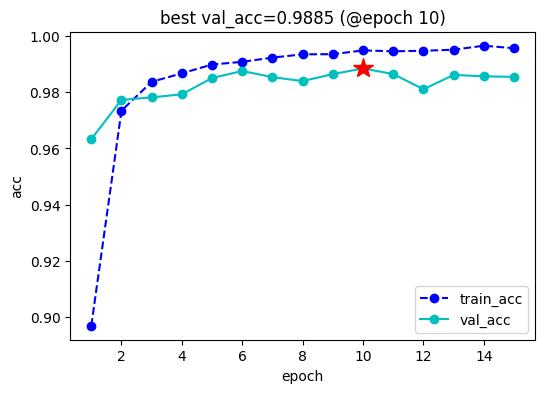

100%|███████████████████████████████| 79/79 [00:02<00:00, 35.97it/s, val_acc=0.989, val_loss=0.0499]


{'val_loss': 0.049907402562307135, 'val_acc': 0.9885000586509705}

In [3]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchkeras #Attention this line 


#================================================================================
# 一，准备数据
#================================================================================

import torchvision 
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)

for features,labels in dl_train:
    break 

#================================================================================
# 二，定义模型
#================================================================================


def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=64,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=64,out_channels=512,kernel_size = 3))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(512,1024))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(1024,10))
    return net

net = create_net()
print(net)

# 评估指标
class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        


#================================================================================
# 三，训练模型
#================================================================================

model = torchkeras.KerasModel(net,
      loss_fn = nn.CrossEntropyLoss(),
      optimizer= torch.optim.Adam(net.parameters(),lr=0.001),
      metrics_dict = {"acc":Accuracy()}
    )

from torchkeras import summary
summary(model,input_data=features);


# if gpu/mps is available, will auto use it, otherwise cpu will be used.

dfhistory=model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=15, 
                    patience=5, 
                    monitor="val_acc",
                    mode="max",
                    ckpt_path='checkpoint')

#================================================================================
# 四，评估模型
#================================================================================

model.evaluate(dl_val)






## 五，M1芯片与CPU和Nvidia GPU速度对比

使用以上代码作为范例，分别在CPU, mac m1芯片，以及Nvidia GPU上 运行。

得到的运行速度截图如下：

纯CPU跑效果
![](https://tva1.sinaimg.cn/large/008vxvgGgy1h8pu8qudibj318i0d0n06.jpg)

Mac M1 芯片加速效果
![](https://tva1.sinaimg.cn/large/008vxvgGgy1h8pubdxbrkj318u0eywhq.jpg)


Tesla P100 GPU加速效果
![](https://tva1.sinaimg.cn/large/008vxvgGgy1h8pu9epg15j319i0dcn0c.jpg)


纯CPU跑一个epoch大约是3min 18s。

使用mac m1芯片加速，一个epoch大约是33 s，相比CPU跑，加速约6倍。

使用Nvidia Tesla P100 GPU加速，一个epoch大约是 8s，相比CPU跑，加速约25倍。

这和pytorch官网显示的训练过程平均加速7倍相当。

![](https://tva1.sinaimg.cn/large/008vxvgGgy1h8putb28ivj30zk0lwq4j.jpg)

整体来说Mac M1芯片对 深度学习训练过程的加速还是非常显著的，通常达到5到7倍左右。

不过目前看和企业中最常使用的高端的Tesla P100 GPU相比，还是有2到4倍的训练速度差异，可以视做一个mini版的GPU吧。








